In [1]:
from __future__ import print_function, division
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter
%pylab notebook
import os
import sys
import numpy as np
import random
import copy
import traceback
import operator
from collections import defaultdict
from pprint import pprint
import string
from graph_tool.all import *
import scipy.stats as stats
from IPython.display import HTML
import pandas as pd
import sys
import os
lib_path = '/home/fgeigl/'
print('append', lib_path)
sys.path.append(lib_path)
import tools.mpl_tools as plt_tools
# import seaborn
matplotlib.rcParams.update({'font.size': 25})
matplotlib.rcParams['xtick.major.pad'] *= 2
matplotlib.rcParams['ytick.major.pad'] *= 2

Populating the interactive namespace from numpy and matplotlib
append /home/fgeigl/


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [79]:

base_path = '/home/fgeigl/navigability_of_networks/output/bias_link_ins/'
out_dir = '/home/fgeigl/navigability_of_networks/output/bias_link_ins/mixture_results/'
in_fname, file_prefix = base_path + 'wiki4schools.gt/wiki4schools.gt_mixture_res.df', 'wiki4s'
in_fname, file_prefix = base_path + 'daserste.gt/daserste.gt_mixture_res.df', 'daserste'
in_fname, file_prefix = base_path + 'tvthek_orf.gt/tvthek_orf.gt_mixture_res.df', 'tvthek_orf'

bs_filter = set([1,2,5,15])
# bs_filter = None

df = pd.read_pickle(in_fname)
df.head(10)
x_label = (r'$_\mathregular{link \, insertion \, \leftarrow\quad}\mathregular{\alpha} _\mathregular{\quad\rightarrow \, bias}$')
# x_label =  r'$\alpha$'
y_label = 'stationary probability'

Sample Size: 0.0100010205123


<IPython.core.display.Javascript object>


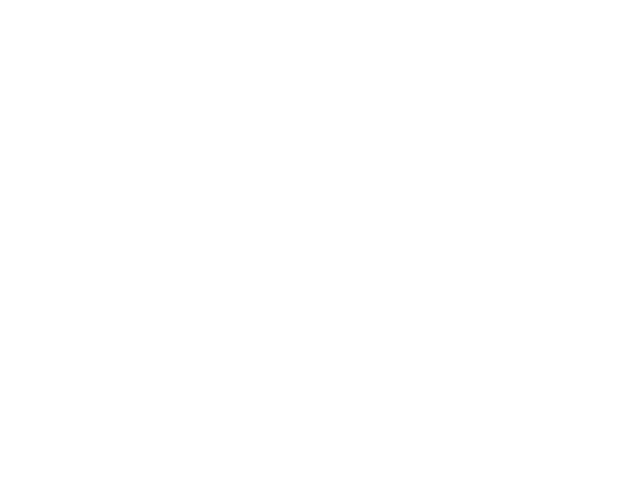

<IPython.core.display.Javascript object>


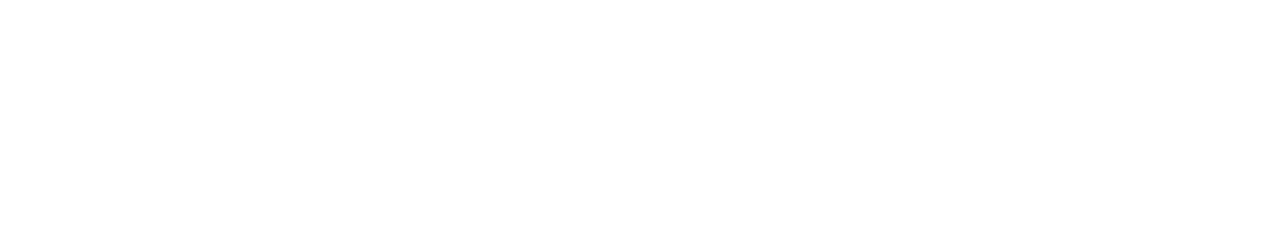

Sample Size: 0.100010205123


<IPython.core.display.Javascript object>


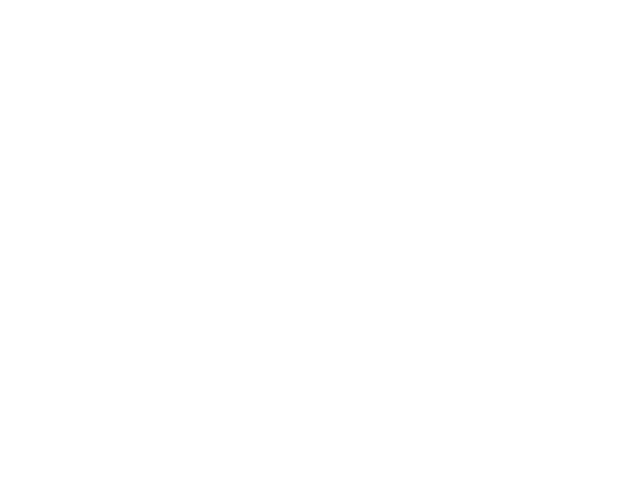

<IPython.core.display.Javascript object>


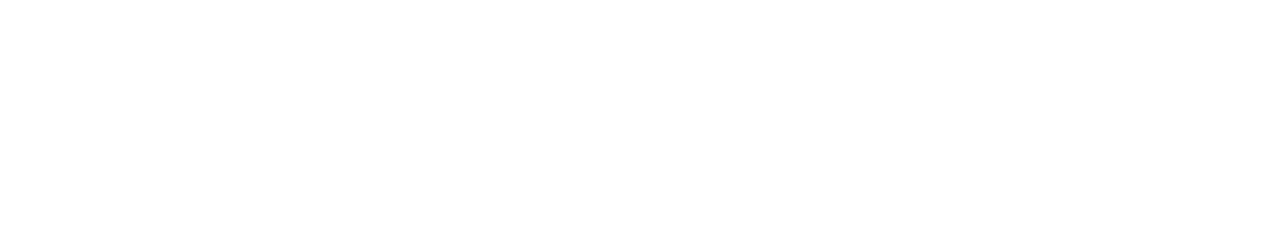

Sample Size: 0.200020410246


<IPython.core.display.Javascript object>


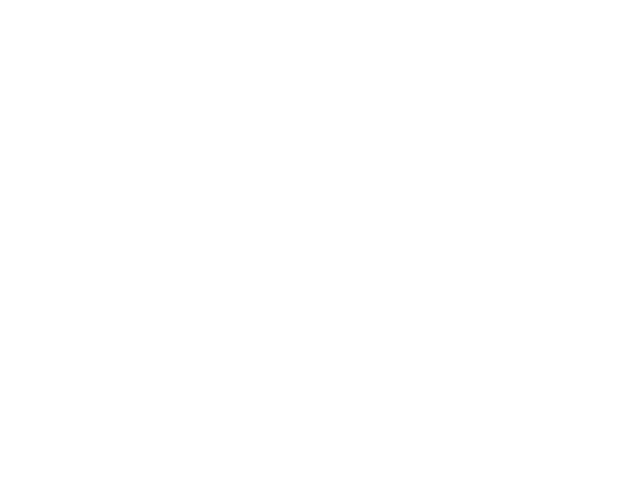

<IPython.core.display.Javascript object>


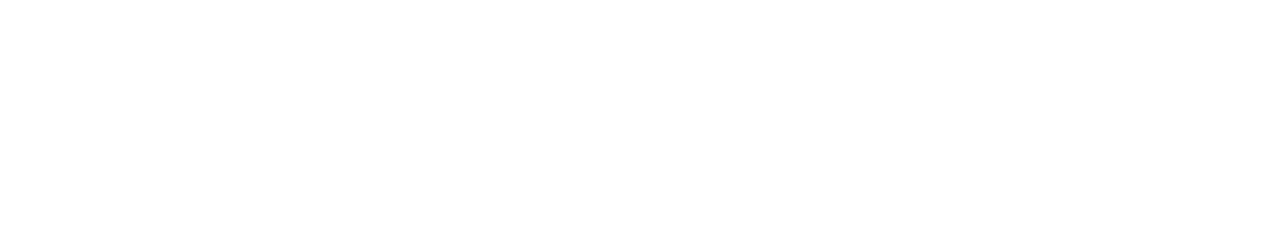

In [80]:
interactive = False
mean_out_folder = out_dir + 'mean/'
os.system('mkdir -p ' + mean_out_folder)
print('='*120)
plot_std = True
for key, grp_df in df.groupby('sample-size'):
    grp_df = grp_df.dropna(how='any')
    if len(grp_df) < 2:
        continue
    grp_count = pd.pivot_table(data=grp_df[['bias_strength', 'mixture', 'sample_stat_dist']], index='mixture', columns='bias_strength', aggfunc='count')
    num_samples = grp_count.iloc[0, 0]
    if num_samples < 2:
        continue
    print('Sample Size:', key)
    grp_means = pd.pivot_table(data=grp_df[['bias_strength', 'mixture', 'sample_stat_dist']], index='mixture', columns='bias_strength', aggfunc='mean')
    grp_std = pd.pivot_table(data=grp_df[['bias_strength', 'mixture', 'sample_stat_dist']], index='mixture', columns='bias_strength', aggfunc='std')

    f, ax = plt.subplots()
    ax.plot([],[],alpha=0.,label='bias strength')
    # print(grp_means)
    colors = ['#ffffd9','#edf8b1','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#253494','#081d58'][-len(grp_means.columns):]
    markers = "ov^<>sp*+x"
    for f_idx, fence in enumerate(grp_means.columns):
        if bs_filter is None or int(fence[-1]) in bs_filter:
            if plot_std:
                col_1 = grp_means[fence] + grp_std[fence]
                col_2 = grp_means[fence] - grp_std[fence]
                ax.fill_between(list(grp_means.index), list(col_1), list(col_2), color=colors[f_idx], alpha=0.25, label=None, interpolate=True)
            ax.plot(list(grp_means.index), list(grp_means[fence]), color=colors[f_idx], marker=markers[f_idx], ms=12, lw=3, label=int(fence[-1]), 
                    markeredgewidth = 2, markeredgecolor = (.99, .99, .99, .9), alpha=1.)

        

    ax.set_xlabel(x_label)
    ax.set_xlim([0, 1.])

    ax.set_ylabel(y_label)
    ax.set_ylim([0., 1.])
    key = "%0.3f" % key
    # plt.title('sample-size: ' + key + ' || # samples: ' + str(num_samples))
    # plt.legend(loc='best')
    # plt.grid()
    ax.grid(b=True, which='major', axis='y', linewidth=3, alpha=0.2, ls='--')
    ax.set_axisbelow(True)
    plt.show()
    fname = mean_out_folder + file_prefix + '_ss_' + key.replace('.','_') + '_mean.pdf'

    plt.tight_layout()
    if not interactive:
        if fname.endswith('.png'):
            plt.savefig(fname, dpi=150)
        else:
            plt.savefig(fname)
        if fname.endswith('.pdf'):
            os.system('pdfcrop ' + fname + ' ' + fname)
        plt_tools.plot_legend(ax, fname.rsplit('/', 1)[0] + '/' + 'legend.pdf', font_size=12, nrows=1, legend_name_idx=0)
        # plt.close('all')

MEAN
Sample Size: 0.0101209577882


<IPython.core.display.Javascript object>


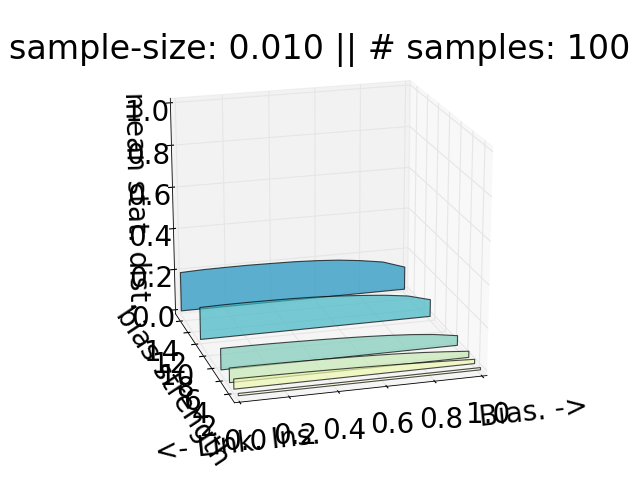

Sample Size: 0.0999753147371


<IPython.core.display.Javascript object>


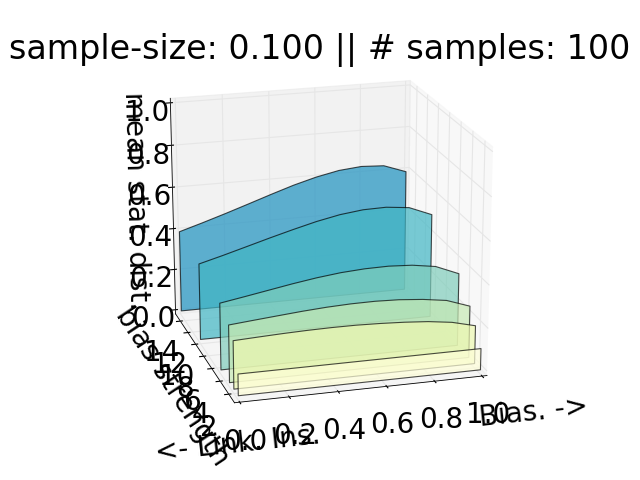

Sample Size: 0.199950629474


<IPython.core.display.Javascript object>


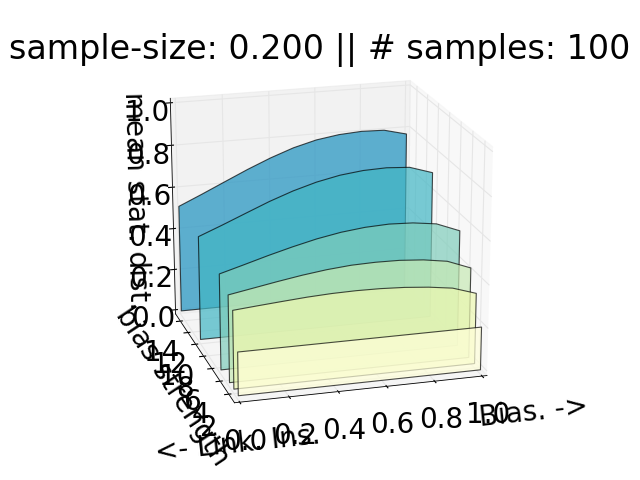

STD
Sample Size: 0.0101209577882


<IPython.core.display.Javascript object>


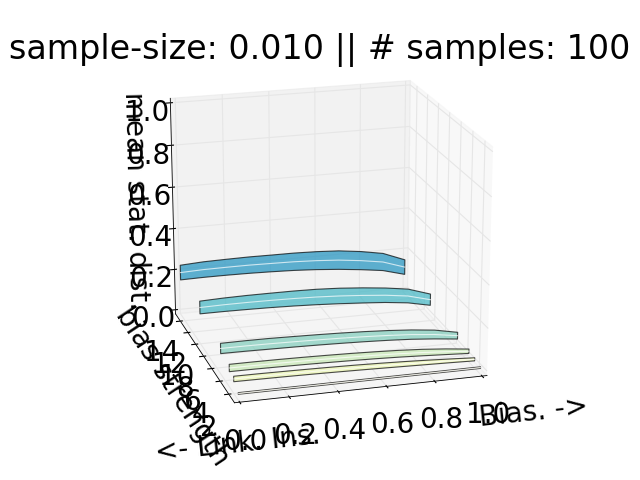

Sample Size: 0.0999753147371


<IPython.core.display.Javascript object>


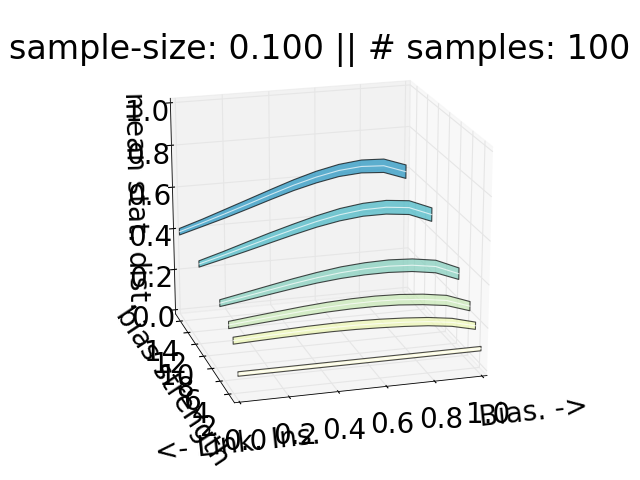

Sample Size: 0.199950629474


<IPython.core.display.Javascript object>


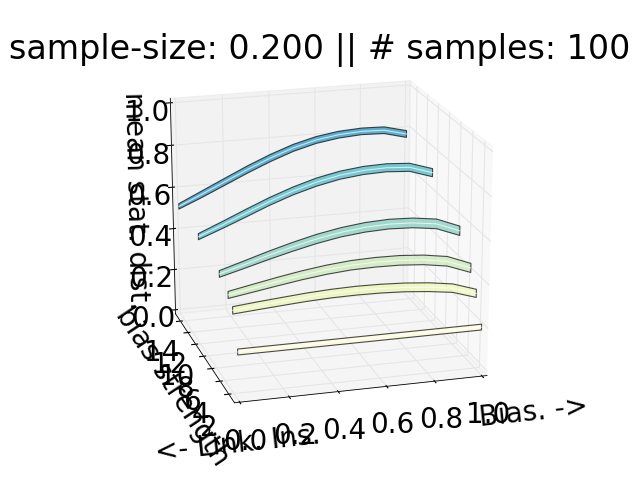

In [4]:
interactive = False
mean_out_folder = out_dir + 'mean3d/'
std_out_folder = out_dir + 'std3d/'
os.system('mkdir -p ' + mean_out_folder)
os.system('mkdir -p ' + std_out_folder)
for plot_std in [False, True]:
    print('='*120)
    if plot_std:
        print('STD')
    else:
        print('MEAN')
    print('='*120)
    for key, grp_df in df.groupby('sample-size'):
        grp_df = grp_df.dropna(how='any')
        if len(grp_df) < 2:
            continue
        grp_count = pd.pivot_table(data=grp_df[['bias_strength', 'mixture', 'sample_stat_dist']], index='mixture', columns='bias_strength', aggfunc='count')
        num_samples = grp_count.iloc[0, 0]
        if num_samples < 2:
            continue
        print('Sample Size:', key)
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        verts = list()
        zs = list()
        grp_means = pd.pivot_table(data=grp_df[['bias_strength', 'mixture', 'sample_stat_dist']], index='mixture', columns='bias_strength', aggfunc='mean')
        grp_std = pd.pivot_table(data=grp_df[['bias_strength', 'mixture', 'sample_stat_dist']], index='mixture', columns='bias_strength', aggfunc='std')
        
        # print(grp_means)
        colors = ['#ffffd9','#edf8b1','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#0c2c84']
        for f_idx, fence in enumerate(grp_means.columns):
            zs.append(fence[-1])
            if plot_std:
                col_1 = grp_means[fence] + grp_std[fence]
                col_2 = grp_means[fence] - grp_std[fence]
                ax.plot(list(grp_means.index), list([fence[-1]]*len(grp_means[fence])), zs=list(grp_means[fence]), c='white', alpha=0.7)
                col_x = list(col.index) + list(reversed(col.index))
                col_d = list(col_1) + list(reversed(list(col_2)))
                verts.append(zip(col_x, col_d))
            else:
                col = grp_means[fence]
                verts.append(zip(col.index, col))
                verts[f_idx].insert(0, (0,0))
                verts[f_idx].append((1,0))
        colors = colors[:len(verts)]
        poly = PolyCollection(verts, facecolors=colors)
        poly.set_alpha(0.7)
        ax.add_collection3d(poly, zs=zs, zdir='y')

        ax.set_xlabel('<- Link. Ins.                  Bias. ->')
        ax.set_xlim3d(0, 1.)

        ax.set_ylabel('bias strength')
        ax.set_ylim3d(zs[0], zs[-1])
        # ax.set_yticks(zs)
        # ax.set_yscale('log')

        ax.set_zlabel('mean stat. dist.')
        ax.set_zlim3d(0., 1.)
        key = "%0.3f" % key
        plt.title('sample-size: ' + key + ' || # samples: ' + str(num_samples))
        ax.view_init(elev=20., azim=-106)
        plt.show()
        if plot_std:
            fname = std_out_folder + file_prefix + '_ss_' + key.replace('.','_') + '_std.png'
        else:
            fname = mean_out_folder + file_prefix + '_ss_' + key.replace('.','_') + '_mean.png'
        
        plt.tight_layout()
        if not interactive:
            if fname.endswith('.png'):
                plt.savefig(fname, dpi=150)
            else:
                plt.savefig(fname)
            os.system('pdfcrop ' + fname + ' ' + fname)